## CS NLP Project 5

In [1]:
import re
import json
import nltk
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
import seaborn as sns

import pandas as pd

from sklearn.decomposition import TruncatedSVD,randomized_svd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

from pyspark import SparkContext
from nltk.util import ngrams

from nltk import pos_tag
import nlu

from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from gensim.models import word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [2]:
notes = pd.read_csv(r'NOTEEVENTS.csv', chunksize = 1000)

In [3]:
df2 = pd.concat([chunk for chunk in notes])

In [4]:
df2.shape

(2083180, 11)

In [5]:
type(df2)

pandas.core.frame.DataFrame

In [6]:
df2.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [7]:
df3 = df2.filter(items=['TEXT'])

In [8]:
df3.head()

,TEXT
0,Admission Date: [**2151-7-16**] Dischar...
1,Admission Date: [**2118-6-2**] Discharg...
2,Admission Date: [**2119-5-4**] D...
3,Admission Date: [**2124-7-21**] ...
4,Admission Date: [**2162-3-3**] D...


In [9]:
sample = np.array_split(df3, 5)

In [10]:
sample[0].shape

(416636, 1)

In [11]:
stop_words = set(stopwords.words('english'))

In [12]:
def preprocess(s):
    s = s.lower()
    re_punc = re.compile(r'[^a-z]+')
    s = re.sub(re_punc,' ',s)
    t = word_tokenize(s)
    lemmas = [WordNetLemmatizer().lemmatize(x) for x in t]
    lemmas = [x for x in lemmas if x not in stop_words and len(x)>2]
    return lemmas

In [13]:
sample[0]['TEXT_preprocess'] = sample[0]['TEXT'].apply(preprocess)
# sample[1]['TEXT_preprocess'] = sample[1]['TEXT'].apply(preprocess)
# sample[2]['TEXT_preprocess'] = sample[2]['TEXT'].apply(preprocess)

In [14]:
def get_lemma(l):
        
    text = ' '.join(l)
    
    return text

In [15]:
sample[0]['LEMMA_TEXT'] = sample[0].TEXT_preprocess.apply(get_lemma)

In [16]:
sample[0].head()

,TEXT,TEXT_preprocess,LEMMA_TEXT
0,Admission Date: [**2151-7-16**] Dischar...,"[admission, date, discharge, date, service, ad...",admission date discharge date service addendum...
1,Admission Date: [**2118-6-2**] Discharg...,"[admission, date, discharge, date, date, birth...",admission date discharge date date birth sex s...
2,Admission Date: [**2119-5-4**] D...,"[admission, date, discharge, date, service, ca...",admission date discharge date service cardioth...
3,Admission Date: [**2124-7-21**] ...,"[admission, date, discharge, date, service, me...",admission date discharge date service medicine...
4,Admission Date: [**2162-3-3**] D...,"[admission, date, discharge, date, date, birth...",admission date discharge date date birth sex s...


In [17]:
lines = []
with open('sample.txt', 'w') as f:
    f.writelines(sample[0].LEMMA_TEXT + "\n" + "\n")

In [18]:
def get_count(c):
    token = word_tokenize(c)
    gram = ngrams(token, 1)
    fd = nltk.FreqDist(gram)
    for k, v in fd.items():
        if v == 2:
            count = k[0]
            return count

In [19]:
sample[0].columns[0]

'TEXT'

<AxesSubplot:title={'center':'Top topics for TEXT'}>

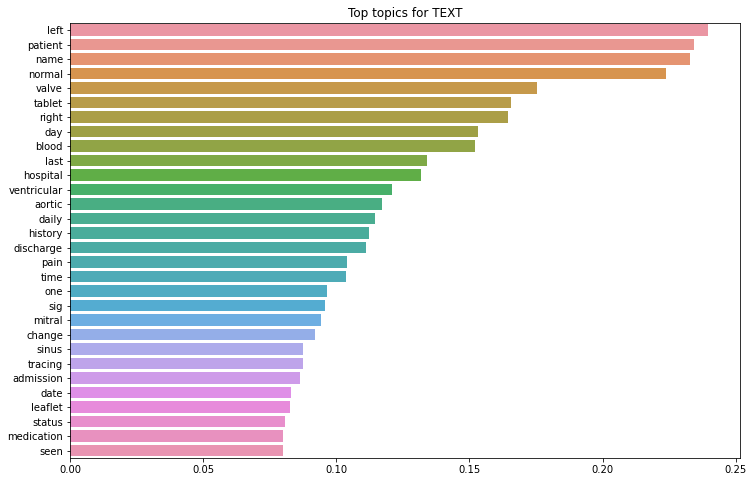

In [20]:
fileObject = open("sample.txt", "r")
# survey.columns[i] = fileObject.read()
docs = fileObject.read()
w = word_tokenize(docs.lower())
set(w) #deduplicate the words
len(set(w))
MW = open("sample.txt", encoding = 'utf-8')
text = MW.read().lower()
get_count('sample.txt')
trans_split = text.split(get_count(docs))
len(trans_split)
trans_split[0]
type(trans_split)
mw = pd.DataFrame(trans_split, columns=[get_count(docs)])
mw.shape
mw.head()
stop_words = set(stopwords.words('english'))

# To improve this model, we could use POS tagging and filter out parts of speech we aren't interested in

def preprocess(s):
    s = s.lower()
    re_punc = re.compile(r'[^a-z]+')
    s = re.sub(re_punc,' ',s)
    t = nltk.word_tokenize(s)
    lemmas = [WordNetLemmatizer().lemmatize(x) for x in t]
    lemmas = [x for x in lemmas if x not in stop_words]
    return lemmas

mw['lemma']=mw[get_count(docs)].apply(preprocess)
mw.head()
countv = CountVectorizer(tokenizer=preprocess)
mwcounts = countv.fit_transform(mw[get_count(docs)])
type(mwcounts)
mwcounts.shape
terms = countv.get_feature_names()
len(terms)
terms[:8]
mw_df = pd.DataFrame(mwcounts.toarray(), columns=terms)
mw_df.head()

lsa_svd = TruncatedSVD(n_components=2, random_state=42)
lsa_mw = lsa_svd.fit_transform(mw_df)
Sigma = lsa_svd.singular_values_
V_T = lsa_svd.components_.T
np.diag(Sigma)
lsa_mw.shape

document_topic_matrix = pd.DataFrame(lsa_mw,
                                 columns=[f'Latent_concept_{r}' for r in range(2)])

document_topic_matrix
V_T.shape
term_topic_matrix = pd.DataFrame(data=V_T, 
                             index = terms, 
                             columns = [f'Latent_concept_{r}' for r in range(0,V_T.shape[1])])



# To improve this model, we could use POS tagging in the preprocess function and filter out parts of 
# speech we aren't interested in

data = term_topic_matrix[f'Latent_concept_0']
data = data.sort_values(ascending=False)
top_30 = data[:30]
fig, ax = plt.subplots(figsize=(12,8))
plt.title('Top topics for TEXT')
# plt.title('Top terms along the axis of Latent concept 0')
sns.barplot(ax=ax,x= top_30.values, y=top_30.index)

In [21]:
sample_sentiment = sample[0].copy()

In [22]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np
from pylab import *

In [23]:
def get_pol(review):
    list1 = [TextBlob(review).sentiment.polarity]
    return list1

In [24]:
def get_sub(review):
    list1 = [TextBlob(review).sentiment.subjectivity]
    return list1

In [25]:
sample_sentiment['Polarity'] = sample_sentiment['LEMMA_TEXT'].apply(get_pol)

In [26]:
sample_sentiment['Subjectivity'] = sample_sentiment['LEMMA_TEXT'].apply(get_sub)

In [27]:
sample_sentiment.head()

,TEXT,TEXT_preprocess,LEMMA_TEXT,Polarity,Subjectivity
0,Admission Date: [**2151-7-16**] Dischar...,"[admission, date, discharge, date, service, ad...",admission date discharge date service addendum...,[0.06785714285714285],[0.3345238095238095]
1,Admission Date: [**2118-6-2**] Discharg...,"[admission, date, discharge, date, date, birth...",admission date discharge date date birth sex s...,[0.041915437170539215],[0.3443245416714806]
2,Admission Date: [**2119-5-4**] D...,"[admission, date, discharge, date, service, ca...",admission date discharge date service cardioth...,[0.014492278554778552],[0.30693032928609865]
3,Admission Date: [**2124-7-21**] ...,"[admission, date, discharge, date, service, me...",admission date discharge date service medicine...,[0.057789575289575276],[0.2955895455895457]
4,Admission Date: [**2162-3-3**] D...,"[admission, date, discharge, date, date, birth...",admission date discharge date date birth sex s...,[0.050780122655122654],[0.4093511647083075]


In [28]:
sample_sentiment2 = sample_sentiment.copy()

In [29]:
import numpy as np

sample_sentiment2['row_num'] = np.arange(len(sample_sentiment2))

In [30]:
len(sample_sentiment2)

416636

In [31]:
sample_sentiment2 = sample_sentiment2.set_index('row_num')

In [32]:
sample_sentiment2.head()

,TEXT,TEXT_preprocess,LEMMA_TEXT,Polarity,Subjectivity
row_num,,,,,
0,Admission Date: [**2151-7-16**] Dischar...,"[admission, date, discharge, date, service, ad...",admission date discharge date service addendum...,[0.06785714285714285],[0.3345238095238095]
1,Admission Date: [**2118-6-2**] Discharg...,"[admission, date, discharge, date, date, birth...",admission date discharge date date birth sex s...,[0.041915437170539215],[0.3443245416714806]
2,Admission Date: [**2119-5-4**] D...,"[admission, date, discharge, date, service, ca...",admission date discharge date service cardioth...,[0.014492278554778552],[0.30693032928609865]
3,Admission Date: [**2124-7-21**] ...,"[admission, date, discharge, date, service, me...",admission date discharge date service medicine...,[0.057789575289575276],[0.2955895455895457]
4,Admission Date: [**2162-3-3**] D...,"[admission, date, discharge, date, date, birth...",admission date discharge date date birth sex s...,[0.050780122655122654],[0.4093511647083075]


In [33]:
polarity = []
subjectivity = []

for i in range(len(sample_sentiment2)):
    polarity.append(sample_sentiment2.Polarity[i])
    subjectivity.append(sample_sentiment2.Subjectivity[i])


  
    

In [34]:
def Average(lst):
    return sum(lst) / len(lst)

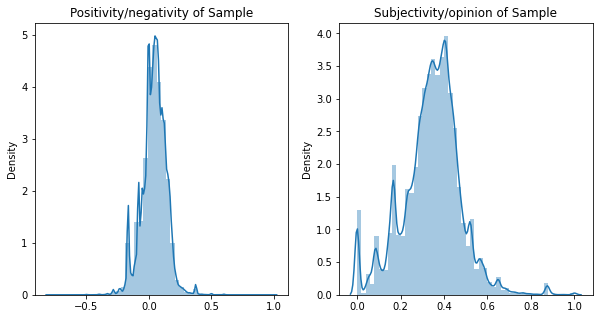

The average for polarity is 0.07087179487179487. The average for subjectivity is 0.3504615384615384.


In [35]:
fig,axes=plt.subplots(1,2, figsize=(10,5))
#plt.xlabel(Average(polarity[i]))
sns.distplot(polarity, ax=axes[0]).set(title = 'Positivity/negativity of Sample')
sns.distplot(subjectivity,ax=axes[1]).set(title = 'Subjectivity/opinion of Sample')
plt.show()
print('The average for polarity is ' + "% s" % Average(polarity[i]) + '. The average for subjectivity is ' + "% s" % Average(subjectivity[i]) + '.')
    

In [36]:
# sample_sentimentDF = np.array_split(sample_sentiment2, 2)

In [37]:
sample_sentiment2.to_csv(r'df_project2.csv', header = None, index = None, sep = ' ')